In [1]:
import os
import numpy as np
import tifffile as tiff
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, UpSampling2D,
                                     concatenate, BatchNormalization, Dropout)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import tensorflow as tf

# Set seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# -------------------------
# SETTINGS
# -------------------------
IMG_SIZE = 128
BATCH_SIZE = 4
MIN_MASK_PIXELS = 100  # For filtering blank patches

IMAGE_DIR = r"C:\Users\KIIT\Downloads\archive (2)\1_CLOUD_FREE_DATASET\2_SENTINEL2\IMAGE_16_GRID"
MASK_DIR  = r"C:\Users\KIIT\Downloads\archive (2)\3_TRAINING_MASKS\MASK_16_GRID"

# -------------------------
# LOSS + METRIC
# -------------------------
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

# Combined loss (optional)
def combined_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * dice_loss(y_true, y_pred)

# -------------------------
# PATCH GENERATOR
# -------------------------
def patch_generator(image_dir, mask_dir, image_list, mask_list,
                    patch_size=IMG_SIZE, batch_size=BATCH_SIZE, augment=True, seed=42):

    image_gen = ImageDataGenerator(
        rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
        shear_range=0.1, zoom_range=0.1, horizontal_flip=True,
        vertical_flip=True, fill_mode='nearest'
    ) if augment else ImageDataGenerator()

    mask_gen = ImageDataGenerator(
        rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
        shear_range=0.1, zoom_range=0.1, horizontal_flip=True,
        vertical_flip=True, fill_mode='nearest'
    ) if augment else ImageDataGenerator()

    while True:
        X_batch, y_batch = [], []
        for _ in range(batch_size * 2):  # try enough times to fill a batch
            idx = np.random.randint(0, len(image_list))
            img_file, mask_file = image_list[idx], mask_list[idx]

            img = tiff.imread(os.path.join(image_dir, img_file))
            mask = tiff.imread(os.path.join(mask_dir, mask_file))

            if img.ndim == 3 and img.shape[2] >= 3:
                img = img[..., [3, 2, 1]]  # B4, B3, B2
            elif img.ndim == 2:
                img = np.stack([img]*3, axis=-1)

            img = img / np.max(img)
            if mask.ndim == 2:
                mask = np.expand_dims(mask, axis=-1)
            mask = (mask / np.max(mask) > 0.5).astype(np.float32)

            h, w = img.shape[:2]
            if h < patch_size or w < patch_size:
                continue

            x = np.random.randint(0, h - patch_size)
            y = np.random.randint(0, w - patch_size)
            img_patch = img[x:x + patch_size, y:y + patch_size]
            mask_patch = mask[x:x + patch_size, y:y + patch_size]

            if np.sum(mask_patch) > MIN_MASK_PIXELS:
                X_batch.append(img_patch)
                y_batch.append(mask_patch)

            if len(X_batch) == batch_size:
                X_batch = np.array(X_batch)
                y_batch = np.array(y_batch)
                if augment:
                    seed_val = np.random.randint(10000)
                    gen_img = image_gen.flow(X_batch, batch_size=batch_size, seed=seed_val, shuffle=False)
                    gen_mask = mask_gen.flow(y_batch, batch_size=batch_size, seed=seed_val, shuffle=False)
                    X_batch = next(gen_img)
                    y_batch = next(gen_mask)
                yield X_batch, y_batch
                X_batch, y_batch = [], []

           

# -------------------------
# U-NET MODEL
# -------------------------
def unet_model(input_size=(IMG_SIZE, IMG_SIZE, 3), dropout_rate=0.3):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)

    # Decoder
    u1 = UpSampling2D()(c3)
    m1 = concatenate([u1, c2])
    c4 = Conv2D(128, 3, activation='relu', padding='same')(m1)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(128, 3, activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)

    u2 = UpSampling2D()(c4)
    m2 = concatenate([u2, c1])
    c5 = Conv2D(64, 3, activation='relu', padding='same')(m2)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(dropout_rate)(c5)
    c5 = Conv2D(64, 3, activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    outputs = Conv2D(1, 1, activation='sigmoid')(c5)
    return Model(inputs, outputs)

# -------------------------
# TRAINING
# -------------------------
# 1. Prepare file lists
all_images = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith('.tif')])
all_masks = sorted([f for f in os.listdir(MASK_DIR) if f.endswith('.tif')])

train_images, val_images, train_masks, val_masks = train_test_split(
    all_images, all_masks, test_size=0.2, random_state=SEED
)

# 2. Generators
train_gen = patch_generator(IMAGE_DIR, MASK_DIR, train_images, train_masks, augment=True)
val_gen = patch_generator(IMAGE_DIR, MASK_DIR, val_images, val_masks, augment=False)

# 3. Model
model = unet_model()
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=combined_loss,  # You can switch to 'binary_crossentropy'
              metrics=['accuracy', dice_coef])

# 4. Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1),
    ModelCheckpoint('unet_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=6, min_lr=1e-6, verbose=1)
]

# 5. Train
history = model.fit(
    train_gen,
    steps_per_epoch=50,
    validation_data=val_gen,
    validation_steps=10,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7662 - dice_coef: 0.7528 - loss: 0.3876
Epoch 1: val_loss improved from None to 0.67243, saving model to unet_best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.8246 - dice_coef: 0.8094 - loss: 0.3206 - val_accuracy: 0.1597 - val_dice_coef: 0.5317 - val_loss: 0.6724 - learning_rate: 1.0000e-04
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8539 - dice_coef: 0.8353 - loss: 0.2795
Epoch 2: val_loss did not improve from 0.67243
50/50 ━━━━━━━━━━━━━━━━━━━━ 86s 2s/step - accuracy: 0.8640 - dice_coef: 0.8395 - loss: 0.2705 - val_accuracy: 0.2573 - val_dice_coef: 0.4058 - val_loss: 0.8142 - learning_rate: 1.0000e-04
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8689 - dice_coef: 0.8559 - loss: 0.2659
Epoch 3: val_loss did not improve from 0.67243
50/50 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.8755 - dice_coef: 0.8566 - loss: 0.2522 - val_accuracy: 0.1286 - val_dice_coef:

In [27]:
from sklearn.model_selection import train_test_split

# Split your data into train + test
all_images = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith('.tif')])
all_masks  = sorted([f for f in os.listdir(MASK_DIR) if f.endswith('.tif')])

train_images, test_images, train_masks, test_masks = train_test_split(
    all_images, all_masks, test_size=0.2, random_state=SEED
)


In [29]:
test_gen = patch_generator(
    IMAGE_DIR, MASK_DIR, test_images, test_masks, 
    augment=False, batch_size=BATCH_SIZE
)


In [11]:
from tensorflow.keras.models import load_model


In [23]:
model.save("unet_final_model.keras")  # Native Keras format
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 128, 128, 64)      │           1,792 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 128, 128, 64)      │             256 │ conv2d[0][0]               │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 128, 128, 64)      │          36,928 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_1         │ (None, 128, 128, 64)      │             256 │ conv2d_1[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 64, 64, 64)        │               0 │ batch_normalization_1[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 64, 64, 128)       │          73,856 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_2         │ (None, 64, 64, 128)       │             512 │ conv2d_2[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 64, 64, 128)       │         147,584 │ batch_normalization_2[0][… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_3         │ (None, 64, 64, 128)       │             512 │ conv2d_3[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 32, 32, 128)       │               0 │ batch_normalization_3[0][… │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 32, 32, 256)       │         295,168 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_4         │ (None, 32, 32, 256)       │           1,024 │ conv2d_4[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 32, 32, 256)       │         590,080 │ batch_normalization_4[0][… │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 3,773,956 (14.40 MB)

 Trainable params: 1,885,697 (7.19 MB)

 Non-trainable params: 2,560 (10.00 KB)

 Optimizer params: 1,885,699 (7.19 MB)

In [25]:
from tensorflow.keras.optimizers import Adam

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=combined_loss,
    metrics=['accuracy', dice_coef]
)


In [31]:
# Training generator (with augmentation)
train_gen = patch_generator(IMAGE_DIR, MASK_DIR, train_images, train_masks, augment=True)

# Validation generator (no augmentation)
val_gen = patch_generator(IMAGE_DIR, MASK_DIR, val_images, val_masks, augment=False)

# Test generator (no augmentation)
test_gen = patch_generator(IMAGE_DIR, MASK_DIR, test_images, test_masks, augment=False)


In [33]:
# Number of steps to cover the entire test set
steps = len(test_images) // BATCH_SIZE

loss, accuracy, dice = model.evaluate(test_gen, steps=steps)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}, Test Dice: {dice:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.9624 - dice_coef: 0.9672 - loss: 0.0764
Test Loss: 0.0764, Test Accuracy: 0.9624, Test Dice: 0.9672


In [ ]:
import os
import numpy as np
import tifffile as tiff

PRED_DIR = r"C:\Users\KIIT\Downloads\predictions"
os.makedirs(PRED_DIR, exist_ok=True)

for i, img_file in enumerate(test_images):
    # Load full image
    img = tiff.imread(os.path.join(IMAGE_DIR, img_file))
    img_norm = img / np.max(img)
    if img.ndim == 2:
        img_norm = np.stack([img_norm]*3, axis=-1)
    
    # Resize/patch if needed, then predict
    img_input = np.expand_dims(img_norm[:IMG_SIZE, :IMG_SIZE, :3], axis=0)
    pred_mask = model.predict(img_input)[0,:,:,0] > 0.5
    
    # Save predicted mask
    tiff.imwrite(os.path.join(PRED_DIR, f"pred_{img_file}"), (pred_mask*255).astype(np.uint8))


In [41]:
import matplotlib.pyplot as plt
import tifffile as tiff
import numpy as np

def visualize_predictions(model, image_dir, mask_dir, val_images, patch_size=128, num_samples=5):
    """
    model       : Trained U-Net model
    image_dir   : Directory containing input images
    mask_dir    : Directory containing masks
    val_images  : List of validation image filenames
    patch_size  : Size of patch (default 128)
    num_samples : Number of random samples to visualize
    """
    if num_samples > len(val_images):
        num_samples = len(val_images)

    selected_indices = np.random.choice(len(val_images), num_samples, replace=False)

    for idx in selected_indices:
        img_file = val_images[idx]
        mask_file = val_images[idx]  # assuming masks have the same filenames

        img = tiff.imread(f"{image_dir}/{img_file}")
        mask = tiff.imread(f"{mask_dir}/{mask_file}")

        # Make sure image has 3 channels
        if img.ndim == 2:
            img = np.stack([img]*3, axis=-1)
        elif img.ndim == 3 and img.shape[2] >= 3:
            img = img[..., [3, 2, 1]]  # B4, B3, B2

        img_input = img / np.max(img)
        img_input = np.expand_dims(img_input, axis=0)

        pred_mask = model.predict(img_input)[0, ..., 0]
        pred_mask = (pred_mask > 0.5).astype(np.float32)

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.title("Input Image")
        plt.imshow(img[..., :3])
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.title("Ground Truth Mask")
        plt.imshow(mask, cmap='gray')
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask, cmap='gray')
        plt.axis('off')

        plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step


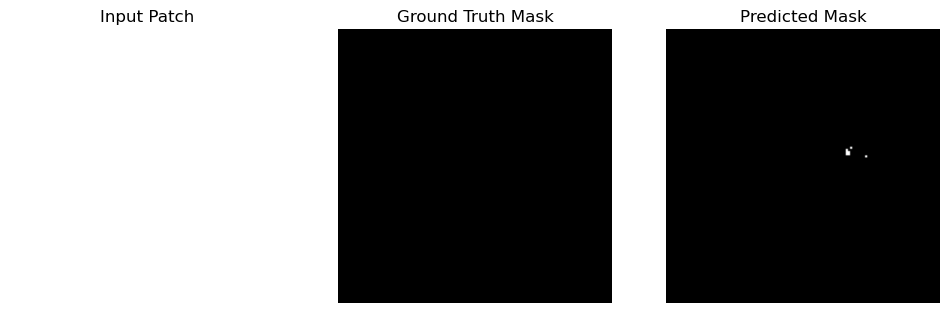

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


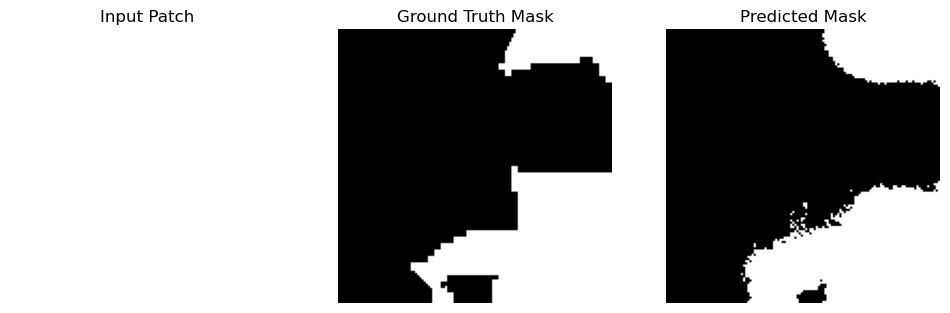

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


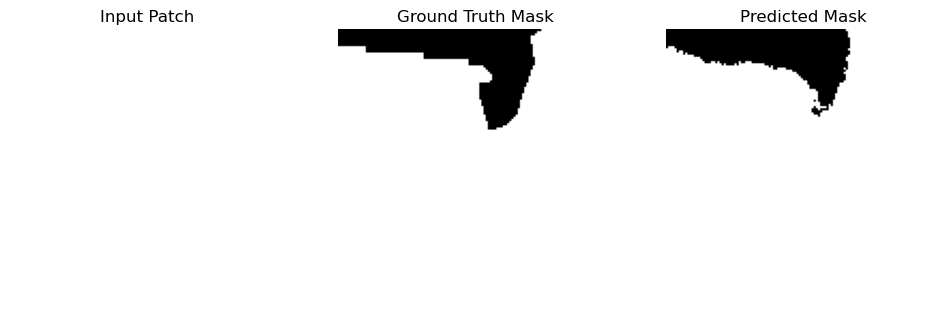

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


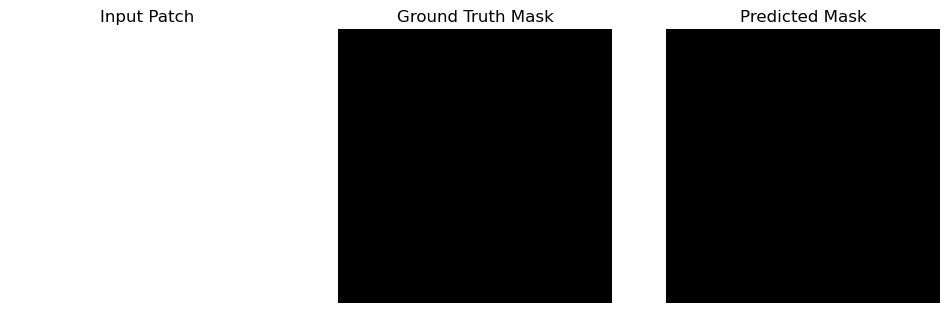

In [45]:
import matplotlib.pyplot as plt
import tifffile as tiff
import numpy as np

def visualize_predictions_patches(model, image_dir, mask_dir, val_images, patch_size=128, num_samples=5):
    if num_samples > len(val_images):
        num_samples = len(val_images)

    selected_indices = np.random.choice(len(val_images), num_samples, replace=False)

    for idx in selected_indices:
        img_file = val_images[idx]
        mask_file = val_images[idx]  # assuming masks have same filename

        img = tiff.imread(f"{image_dir}/{img_file}")
        mask = tiff.imread(f"{mask_dir}/{mask_file}")

        # Ensure 3 channels
        if img.ndim == 2:
            img = np.stack([img]*3, axis=-1)
        elif img.ndim == 3 and img.shape[2] >= 3:
            img = img[..., [3, 2, 1]]  # B4,B3,B2

        h, w, _ = img.shape

        # Random crop patch
        x = np.random.randint(0, h - patch_size)
        y = np.random.randint(0, w - patch_size)
        img_patch = img[x:x+patch_size, y:y+patch_size]
        mask_patch = mask[x:x+patch_size, y:y+patch_size]

        img_input = img_patch / np.max(img_patch)
        img_input = np.expand_dims(img_input, axis=0)

        pred_mask = model.predict(img_input)[0, ..., 0]
        pred_mask = (pred_mask > 0.5).astype(np.float32)

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.title("Input Patch")
        plt.imshow(img_patch[..., :3])
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.title("Ground Truth Mask")
        plt.imshow(mask_patch, cmap='gray')
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.title("Predicted Mask")
        plt.imshow(pred_mask, cmap='gray')
        plt.axis('off')

        plt.show()

# Example usage:
visualize_predictions_patches(model, IMAGE_DIR, MASK_DIR, val_images, patch_size=128, num_samples=5)


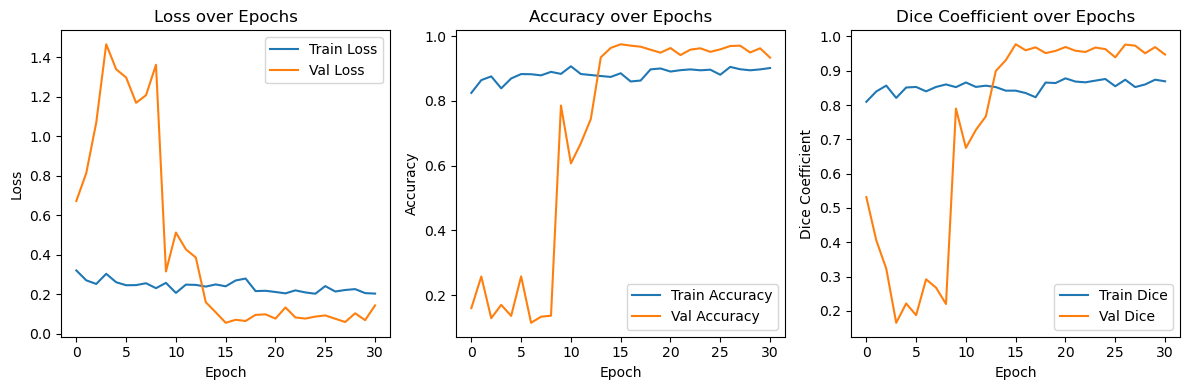

In [47]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    # Plot Loss
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1,3,2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Dice Coefficient
    plt.subplot(1,3,3)
    plt.plot(history.history['dice_coef'], label='Train Dice')
    plt.plot(history.history['val_dice_coef'], label='Val Dice')
    plt.title('Dice Coefficient over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_training_history(history)


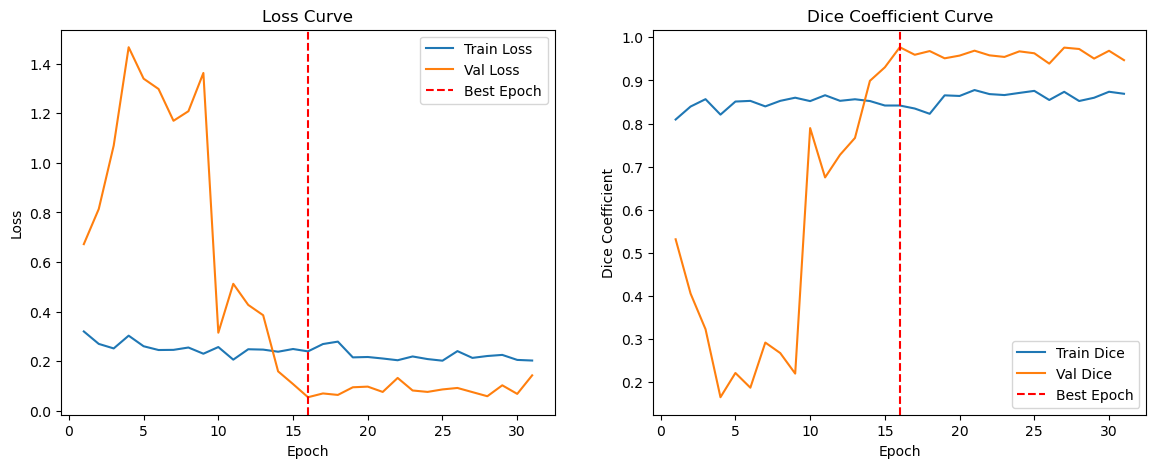

In [49]:
import matplotlib.pyplot as plt

def plot_training_history(history, best_epoch=None):
    """
    history: Keras History object
    best_epoch: int, optional, epoch of best validation metric
    """
    epochs = range(1, len(history.history['loss']) + 1)
    
    plt.figure(figsize=(14,5))
    
    # Loss
    plt.subplot(1,2,1)
    plt.plot(epochs, history.history['loss'], label='Train Loss')
    plt.plot(epochs, history.history['val_loss'], label='Val Loss')
    if best_epoch:
        plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Epoch')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Dice Coefficient
    plt.subplot(1,2,2)
    plt.plot(epochs, history.history['dice_coef'], label='Train Dice')
    plt.plot(epochs, history.history['val_dice_coef'], label='Val Dice')
    if best_epoch:
        plt.axvline(x=best_epoch, color='r', linestyle='--', label='Best Epoch')
    plt.title('Dice Coefficient Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()
    
    plt.show()

# Example usage
plot_training_history(history, best_epoch=16)


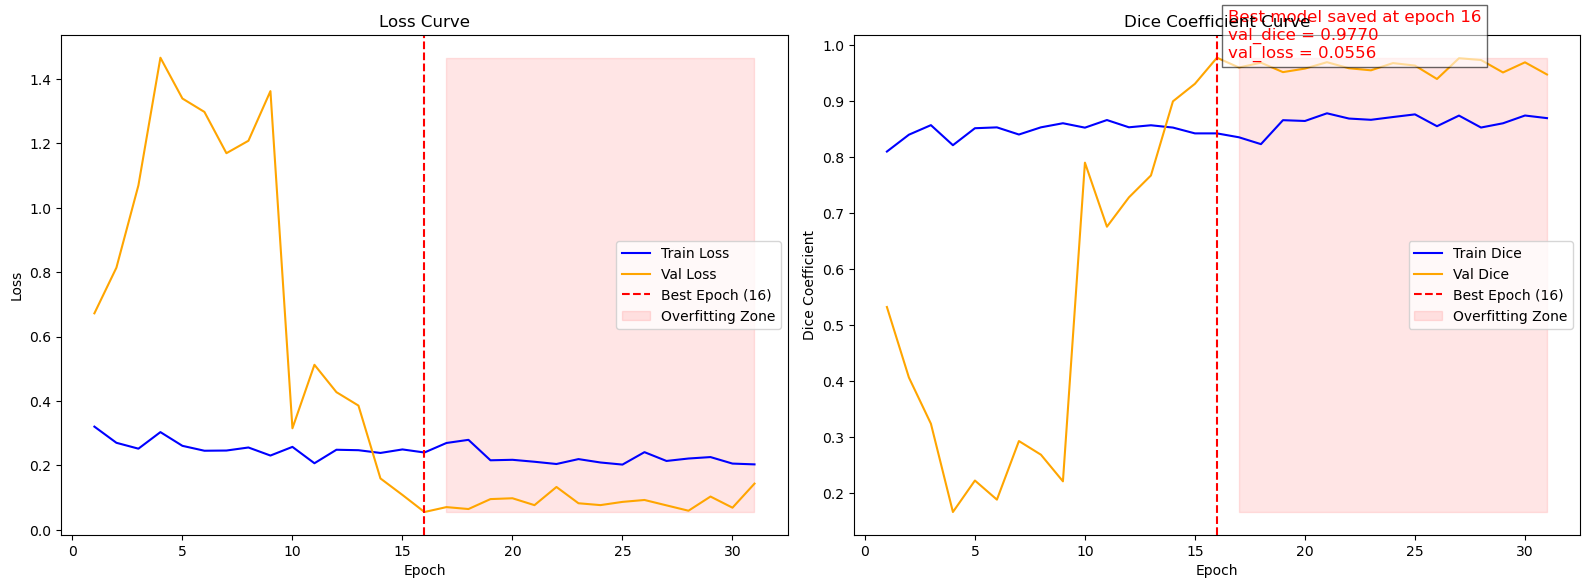

In [51]:
import matplotlib.pyplot as plt

def plot_training_history_with_best(history, best_epoch=16):
    """
    Plots training and validation loss and Dice coefficient.
    Highlights the best epoch and optionally shades the overfitting zone.
    """
    epochs = range(1, len(history.history['loss']) + 1)
    
    best_val_dice = history.history['val_dice_coef'][best_epoch-1]
    best_val_loss = history.history['val_loss'][best_epoch-1]
    
    plt.figure(figsize=(16,6))
    
    # Loss subplot
    plt.subplot(1,2,1)
    plt.plot(epochs, history.history['loss'], label='Train Loss', color='blue')
    plt.plot(epochs, history.history['val_loss'], label='Val Loss', color='orange')
    plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
    plt.fill_between(epochs[best_epoch:], min(history.history['val_loss']), max(history.history['val_loss']), 
                     color='red', alpha=0.1, label='Overfitting Zone')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Dice coefficient subplot
    plt.subplot(1,2,2)
    plt.plot(epochs, history.history['dice_coef'], label='Train Dice', color='blue')
    plt.plot(epochs, history.history['val_dice_coef'], label='Val Dice', color='orange')
    plt.axvline(x=best_epoch, color='red', linestyle='--', label=f'Best Epoch ({best_epoch})')
    plt.fill_between(epochs[best_epoch:], min(history.history['val_dice_coef']), max(history.history['val_dice_coef']), 
                     color='red', alpha=0.1, label='Overfitting Zone')
    plt.title('Dice Coefficient Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Coefficient')
    plt.legend()
    
    # Annotate best epoch
    plt.text(best_epoch+0.5, best_val_dice, 
             f"Best model saved at epoch {best_epoch}\nval_dice = {best_val_dice:.4f}\nval_loss = {best_val_loss:.4f}",
             color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.6))
    
    plt.tight_layout()
    plt.show()

# Usage
plot_training_history_with_best(history, best_epoch=16)


In [55]:
import os

IMAGE_DIR = r"C:\Users\KIIT\Downloads\archive (2)\1_CLOUD_FREE_DATASET\2_SENTINEL2\IMAGE_16_GRID"
MASK_DIR  = r"C:\Users\KIIT\Downloads\archive (2)\3_TRAINING_MASKS\MASK_16_GRID"

print("Number of images:", len(os.listdir(IMAGE_DIR)))
print("Number of masks :", len(os.listdir(MASK_DIR)))


Number of images: 22
Number of masks : 16


In [59]:
import tifffile as tiff

sample_img = tiff.imread(os.path.join(IMAGE_DIR, image_files[0]))
sample_mask = tiff.imread(os.path.join(MASK_DIR, mask_files[0]))

print("Sample image shape:", sample_img.shape)
print("Sample mask shape :", sample_mask.shape)


Sample image shape: (2816, 2816, 4)
Sample mask shape : (2816, 2816)


Number of images: 22
Number of masks : 16


Sample image shape: (2816, 2816, 4)
Sample mask shape : (2816, 2816)


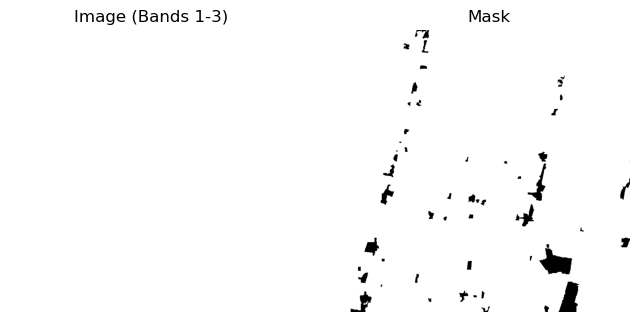

In [65]:
import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt

# Paths
IMAGE_DIR = r"C:\Users\KIIT\Downloads\archive (2)\1_CLOUD_FREE_DATASET\2_SENTINEL2\IMAGE_16_GRID"
MASK_DIR  = r"C:\Users\KIIT\Downloads\archive (2)\3_TRAINING_MASKS\MASK_16_GRID"

image_files = os.listdir(IMAGE_DIR)
mask_files  = os.listdir(MASK_DIR)

print("Number of images:", len(image_files))
print("Number of masks :", len(mask_files))

# Function to read Sentinel-2 GeoTIFFs
def load_sentinel_image(path):
    with rasterio.open(path) as src:
        img = src.read()  # shape: (bands, height, width)
        img = np.transpose(img, (1, 2, 0))  # convert to (height, width, bands)
    return img

def load_mask(path):
    with rasterio.open(path) as src:
        mask = src.read(1)  # single channel
    return mask

# Load a sample
sample_img = load_sentinel_image(os.path.join(IMAGE_DIR, image_files[0]))
sample_mask = load_mask(os.path.join(MASK_DIR, mask_files[0]))

print("Sample image shape:", sample_img.shape)
print("Sample mask shape :", sample_mask.shape)

# Visualize first 3 bands as RGB
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(sample_img[:,:,0:3])  # first 3 bands
plt.title("Image (Bands 1-3)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(sample_mask, cmap='gray')
plt.title("Mask")
plt.axis("off")
plt.show()


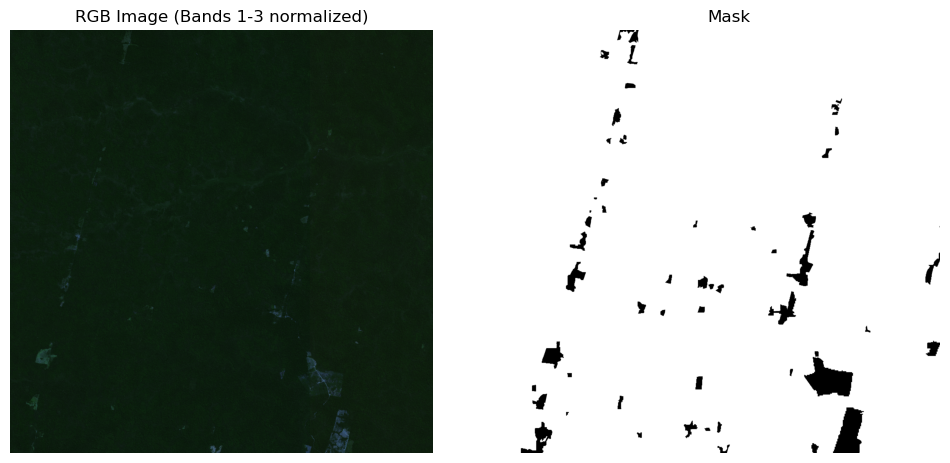

In [67]:
import matplotlib.pyplot as plt


img_display = sample_img[:,:,0:3].astype(np.float32)
img_display = (img_display - img_display.min()) / (img_display.max() - img_display.min())

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(img_display)
plt.title("RGB Image (Bands 1-3 normalized)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(sample_mask, cmap='gray')
plt.title("Mask")
plt.axis("off")
plt.show()


Number of paired images: 16
Mask coverage (min, max, mean): 1.0000, 1.0000, 1.0000
Mask coverage (min, max, mean): 1.0000, 1.0000, 1.0000


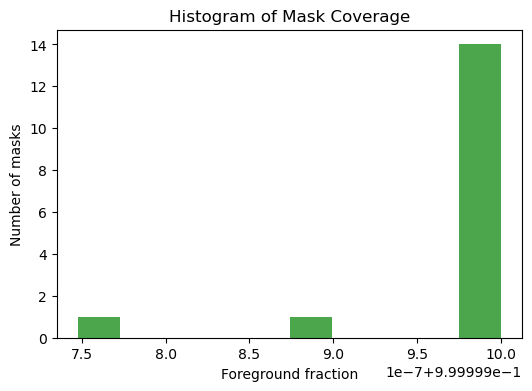

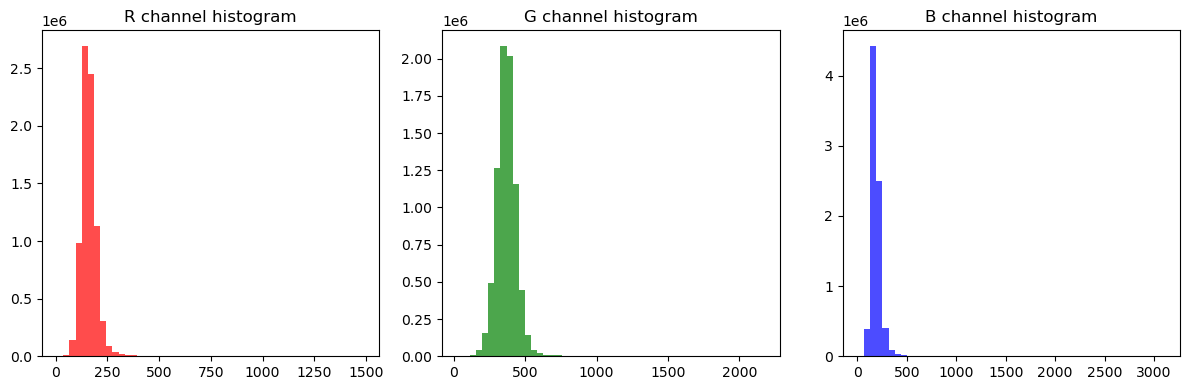

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step


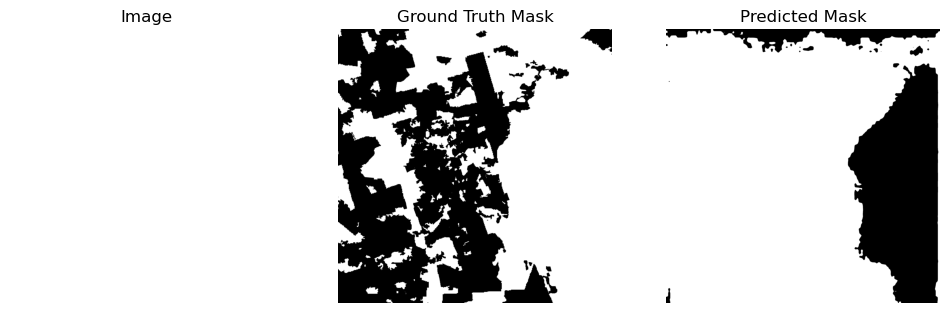

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


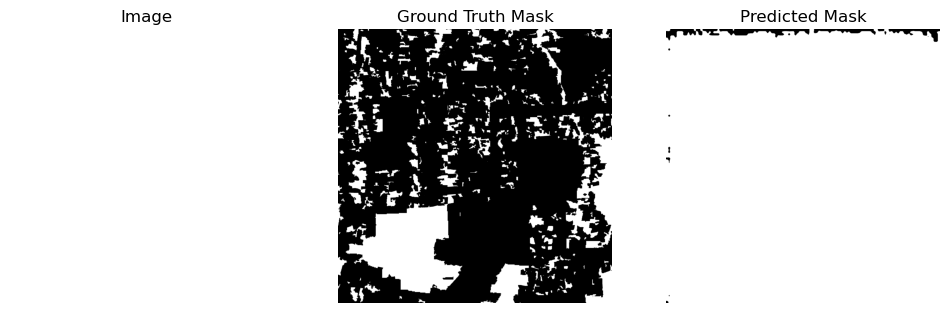

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


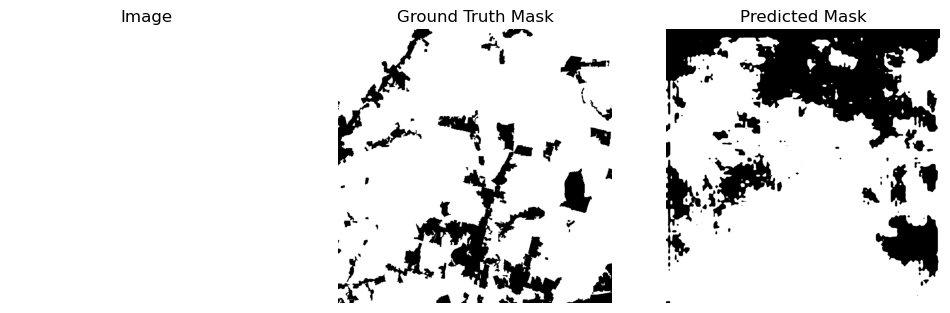

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


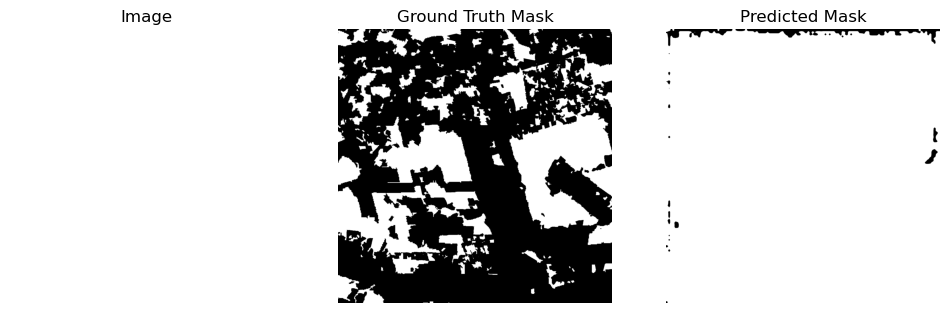

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step


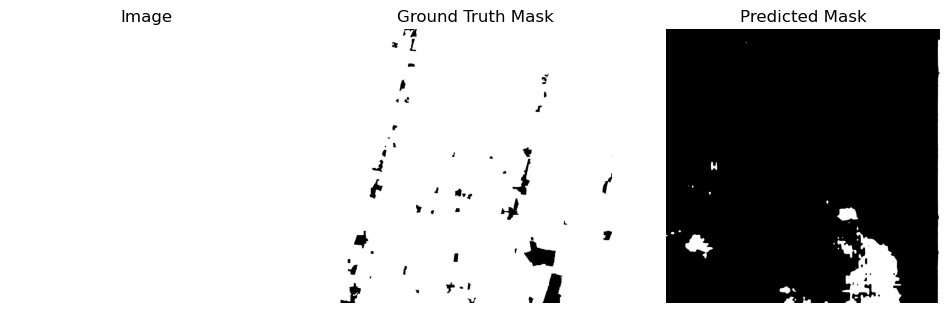

In [71]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random
from tensorflow.keras.models import load_model

# -----------------------------
# Paths
# -----------------------------
IMAGE_DIR = r"C:\Users\KIIT\Downloads\archive (2)\1_CLOUD_FREE_DATASET\2_SENTINEL2\IMAGE_16_GRID"
MASK_DIR  = r"C:\Users\KIIT\Downloads\archive (2)\3_TRAINING_MASKS\MASK_16_GRID"

# -----------------------------
# Helper Functions
# -----------------------------
def load_image(path, color=True):
    if color:
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        if img is None:
            raise ValueError(f"Cannot read image: {path}")
        if img.shape[-1] == 4:
            img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Cannot read mask: {path}")
    return img

def mask_coverage(mask):
    return np.sum(mask > 0) / mask.size

# -----------------------------
# EDA: Check image-mask pairs
# -----------------------------
# -----------------------------
# Correct image-mask pairing
# -----------------------------
image_files = sorted([f for f in os.listdir(IMAGE_DIR) if f.endswith('.tif')])
mask_files  = sorted([f for f in os.listdir(MASK_DIR) if f.endswith('.tif')])

# Ensure image-mask alignment
paired_files = []
for img in image_files:
    # Try to find a mask that matches the image name (adjust naming logic if needed)
    for m in mask_files:
        if img.split('.')[0] in m:  # simple substring match
            paired_files.append((img, m))
            break

print(f"Number of paired images: {len(paired_files)}")

if len(paired_files) == 0:
    print("No paired images found! Check naming conventions.")
else:
    # Compute mask coverage
    mask_coverages = []
    for _, mask_name in paired_files:
        mask_path = os.path.join(MASK_DIR, mask_name)
        mask = load_image(mask_path, color=False)
        mask_coverages.append(mask_coverage(mask))

    print(f"Mask coverage (min, max, mean): {np.min(mask_coverages):.4f}, {np.max(mask_coverages):.4f}, {np.mean(mask_coverages):.4f}")

# -----------------------------
# Sample stats
# -----------------------------
mask_coverages = []
for _, mask_name in paired_files:
    mask_path = os.path.join(MASK_DIR, mask_name)
    mask = load_image(mask_path, color=False)
    mask_coverages.append(mask_coverage(mask))

print(f"Mask coverage (min, max, mean): {np.min(mask_coverages):.4f}, {np.max(mask_coverages):.4f}, {np.mean(mask_coverages):.4f}")

# Plot histogram of mask coverage
plt.figure(figsize=(6,4))
plt.hist(mask_coverages, bins=10, color='green', alpha=0.7)
plt.title("Histogram of Mask Coverage")
plt.xlabel("Foreground fraction")
plt.ylabel("Number of masks")
plt.show()

# -----------------------------
# Band-wise statistics of images
# -----------------------------
sample_img = load_image(os.path.join(IMAGE_DIR, paired_files[0][0]))
plt.figure(figsize=(12,4))
for i, color_name in enumerate(['R','G','B']):
    plt.subplot(1,3,i+1)
    plt.hist(sample_img[:,:,i].ravel(), bins=50, color=color_name.lower(), alpha=0.7)
    plt.title(f"{color_name} channel histogram")
plt.tight_layout()
plt.show()

# -----------------------------
# Load model
# -----------------------------
model = load_model("unet_best_model.keras", compile=False)

# -----------------------------
# Prediction Visualization
# -----------------------------
def visualize_predictions(model, paired_files, image_dir, mask_dir, num_samples=5, patch_size=128):
    selected = random.sample(paired_files, min(num_samples, len(paired_files)))
    
    for img_name, mask_name in selected:
        img = load_image(os.path.join(image_dir, img_name))
        mask = load_image(os.path.join(mask_dir, mask_name), color=False)
        
        # Resize to patch_size for model prediction if needed
        img_resized = cv2.resize(img, (patch_size, patch_size))
        img_input = img_resized / 255.0
        img_input = np.expand_dims(img_input, axis=0)
        
        pred_mask = model.predict(img_input)[0,...,0]
        pred_mask = cv2.resize(pred_mask, (mask.shape[1], mask.shape[0]))
        pred_mask_bin = (pred_mask > 0.5).astype(np.uint8)
        
        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis('off')
        
        plt.subplot(1,3,2)
        plt.imshow(mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')
        
        plt.subplot(1,3,3)
        plt.imshow(pred_mask_bin, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
        
        plt.show()

# Example usage
visualize_predictions(model, paired_files, IMAGE_DIR, MASK_DIR, num_samples=5)


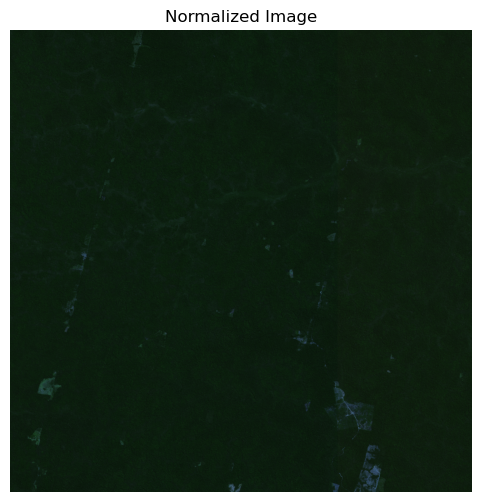

In [73]:
import matplotlib.pyplot as plt

# Load your image (e.g., using load_image)
img = load_image(os.path.join(IMAGE_DIR, paired_files[0][0]))

# Normalize to 0-1 for plotting
img_norm = img.astype('float32')
img_norm = (img_norm - img_norm.min()) / (img_norm.max() - img_norm.min())

plt.figure(figsize=(6,6))
plt.imshow(img_norm)
plt.title("Normalized Image")
plt.axis('off')
plt.show()


61/61 ━━━━━━━━━━━━━━━━━━━━ 27s 429ms/step


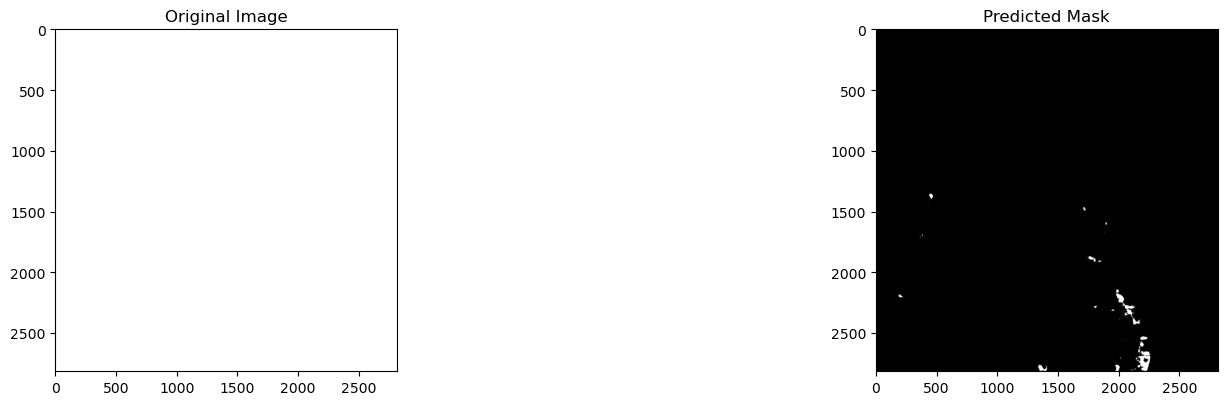

ValueError: Cannot read image: C:\Users\KIIT\Downloads\archive (2)\1_CLOUD_FREE_DATASET\2_SENTINEL2\IMAGE_16_GRID\RASTER_0.tif.aux.xml

In [77]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.models import load_model

# Paths
IMAGE_DIR = r"C:\Users\KIIT\Downloads\archive (2)\1_CLOUD_FREE_DATASET\2_SENTINEL2\IMAGE_16_GRID"
MASK_DIR  = r"C:\Users\KIIT\Downloads\archive (2)\3_TRAINING_MASKS\MASK_16_GRID"

PATCH_SIZE = 128  # Patch size used in training

# Load your trained model
model = load_model("unet_best_model.keras", compile=False)

# ----- Helper Functions -----

def load_image(path, color=True):
    """Load image and handle 4-channel images by taking first 3 channels"""
    if color:
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        if img is None:
            raise ValueError(f"Cannot read image: {path}")
        if img.shape[2] == 4:
            img = img[..., :3]  # take RGB channels only
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    return img

def preprocess(img):
    """Normalize image to 0-1"""
    return img / np.max(img)

def extract_patches(img, patch_size):
    """Split large image into non-overlapping patches"""
    h, w, c = img.shape
    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = img[i:i+patch_size, j:j+patch_size, :]
            # Pad if smaller than patch size
            if patch.shape[0] != patch_size or patch.shape[1] != patch_size:
                patch = cv2.copyMakeBorder(patch, 0, patch_size - patch.shape[0],
                                           0, patch_size - patch.shape[1], cv2.BORDER_REFLECT)
            patches.append(patch)
    return np.array(patches), h, w

def stitch_patches(patches, height, width, patch_size):
    """Reconstruct the full image from patches"""
    c = patches.shape[-1]
    img = np.zeros((height, width, c))
    idx = 0
    for i in range(0, height, patch_size):
        for j in range(0, width, patch_size):
            img[i:i+patch_size, j:j+patch_size, :] = patches[idx][:min(patch_size, height-i), :min(patch_size, width-j), :]
            idx += 1
    return img

# ----- Prediction and Visualization -----

image_files = os.listdir(IMAGE_DIR)

for img_file in image_files[:5]:  # visualize first 5 images
    img_path = os.path.join(IMAGE_DIR, img_file)
    img = load_image(img_path)
    
    # Extract patches
    patches, h, w = extract_patches(preprocess(img), PATCH_SIZE)
    
    # Predict each patch
    pred_patches = model.predict(patches, batch_size=8)
    pred_patches = (pred_patches[..., 0] > 0.5).astype(np.float32)  # Binary mask
    
    # Stitch back
    pred_mask = stitch_patches(pred_patches[..., np.newaxis], h, w, PATCH_SIZE)
    
    # Load ground truth mask if available
    mask_file = img_file.replace("RASTER", "MASK")  # adjust naming as per your dataset
    mask_path = os.path.join(MASK_DIR, mask_file)
    if os.path.exists(mask_path):
        true_mask = load_image(mask_path, color=False)
    else:
        true_mask = None
    
    # Plot
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Original Image")
    
    if true_mask is not None:
        plt.subplot(1,3,2)
        plt.imshow(true_mask, cmap="gray")
        plt.title("Ground Truth Mask")
    
    plt.subplot(1,3,3)
    plt.imshow(pred_mask, cmap="gray")
    plt.title("Predicted Mask")
    
    plt.show()


Number of valid images: 16
Number of valid masks : 1
61/61 ━━━━━━━━━━━━━━━━━━━━ 33s 534ms/step


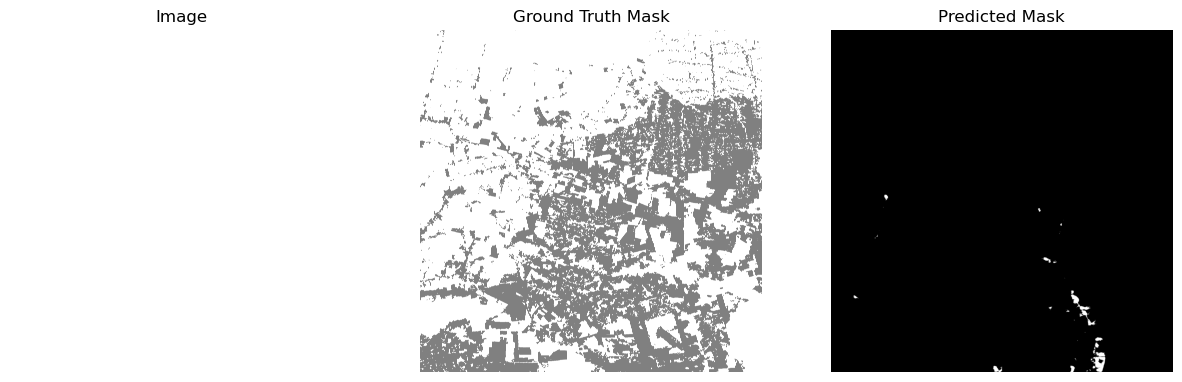

In [80]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# -----------------------------
# Paths
# -----------------------------
IMAGE_DIR = r"C:\Users\KIIT\Downloads\archive (2)\1_CLOUD_FREE_DATASET\2_SENTINEL2\IMAGE_16_GRID"
MASK_DIR  = r"C:\Users\KIIT\Downloads\archive (2)\3_TRAINING_MASKS\MASK_FULL"
MODEL_PATH = r"unet_best_model.keras"

# -----------------------------
# Load trained model
# -----------------------------
model = load_model(MODEL_PATH, compile=False)

# -----------------------------
# Helper function: safe image loader
# -----------------------------
def load_image(path, color=True):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"Cannot read image: {path}")
    # Take only RGB channels if image has 4 channels
    if color and img.shape[-1] == 4:
        img = img[..., :3]
    # Convert BGR to RGB if color
    if color:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# -----------------------------
# Filter only valid TIFF files
# -----------------------------
image_files = [f for f in os.listdir(IMAGE_DIR) if f.lower().endswith('.tif')]
mask_files  = [f for f in os.listdir(MASK_DIR)  if f.lower().endswith('.tif')]

print(f"Number of valid images: {len(image_files)}")
print(f"Number of valid masks : {len(mask_files)}")

# -----------------------------
# Preprocessing for U-Net input
# -----------------------------
def preprocess(img):
    img = img.astype(np.float32)
    img = img / np.max(img)  # normalize to [0,1]
    return img

# -----------------------------
# Patch extraction (for large images)
# -----------------------------
PATCH_SIZE = 128

def extract_patches(img, patch_size=PATCH_SIZE):
    """Extract non-overlapping patches from an image"""
    h, w = img.shape[:2]
    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = img[i:i+patch_size, j:j+patch_size]
            if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                patches.append(patch)
    patches = np.array(patches)
    return patches, h, w

def stitch_patches(pred_patches, h, w, patch_size=PATCH_SIZE):
    """Stitch predicted patches back into full image"""
    full_pred = np.zeros((h, w), dtype=np.float32)
    idx = 0
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            if idx < len(pred_patches):
                full_pred[i:i+patch_size, j:j+patch_size] = pred_patches[idx]
                idx += 1
    return full_pred

# -----------------------------
# Visualization function
# -----------------------------
def visualize_predictions(model, image_files, mask_files, num_samples=3):
    for img_file, mask_file in zip(image_files[:num_samples], mask_files[:num_samples]):
        img_path = os.path.join(IMAGE_DIR, img_file)
        mask_path = os.path.join(MASK_DIR, mask_file)

        img = load_image(img_path)
        mask = load_image(mask_path, color=False)

        # Extract patches
        patches, h, w = extract_patches(preprocess(img))
        patches = patches[..., :3]  # ensure only 3 channels

        # Predict
        pred_patches = model.predict(patches, batch_size=8)
        pred_patches = (pred_patches[..., 0] > 0.5).astype(np.float32)

        # Stitch
        pred_mask = stitch_patches(pred_patches, h, w)

        # Plot
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.show()

# -----------------------------
# Run visualization
# -----------------------------
visualize_predictions(model, image_files, mask_files, num_samples=3)


Number of valid images: 1
Number of valid masks : 1
968/968 ━━━━━━━━━━━━━━━━━━━━ 523s 540ms/step


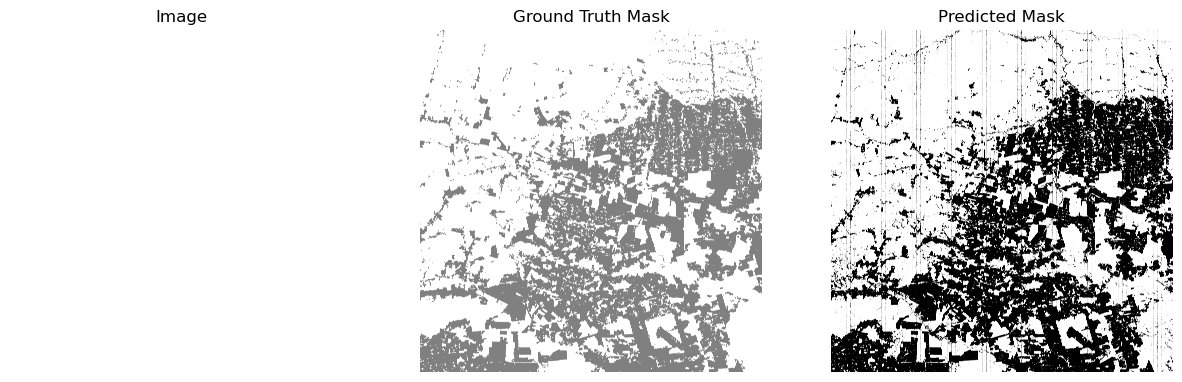

In [82]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# -----------------------------
# Paths
# -----------------------------
IMAGE_DIR = r"C:\Users\KIIT\Downloads\archive (2)\1_CLOUD_FREE_DATASET\2_SENTINEL2\IMAGE_FULL"
MASK_DIR  = r"C:\Users\KIIT\Downloads\archive (2)\3_TRAINING_MASKS\MASK_FULL"
MODEL_PATH = r"unet_best_model.keras"

# -----------------------------
# Load trained model
# -----------------------------
model = load_model(MODEL_PATH, compile=False)

# -----------------------------
# Helper function: safe image loader
# -----------------------------
def load_image(path, color=True):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise ValueError(f"Cannot read image: {path}")
    # Take only RGB channels if image has 4 channels
    if color and img.shape[-1] == 4:
        img = img[..., :3]
    # Convert BGR to RGB if color
    if color:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# -----------------------------
# Filter only valid TIFF files
# -----------------------------
image_files = [f for f in os.listdir(IMAGE_DIR) if f.lower().endswith('.tif')]
mask_files  = [f for f in os.listdir(MASK_DIR)  if f.lower().endswith('.tif')]

print(f"Number of valid images: {len(image_files)}")
print(f"Number of valid masks : {len(mask_files)}")

# -----------------------------
# Preprocessing for U-Net input
# -----------------------------
def preprocess(img):
    img = img.astype(np.float32)
    img = img / np.max(img)  # normalize to [0,1]
    return img

# -----------------------------
# Patch extraction (for large images)
# -----------------------------
PATCH_SIZE = 128

def extract_patches(img, patch_size=PATCH_SIZE):
    """Extract non-overlapping patches from an image"""
    h, w = img.shape[:2]
    patches = []
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            patch = img[i:i+patch_size, j:j+patch_size]
            if patch.shape[0] == patch_size and patch.shape[1] == patch_size:
                patches.append(patch)
    patches = np.array(patches)
    return patches, h, w

def stitch_patches(pred_patches, h, w, patch_size=PATCH_SIZE):
    """Stitch predicted patches back into full image"""
    full_pred = np.zeros((h, w), dtype=np.float32)
    idx = 0
    for i in range(0, h, patch_size):
        for j in range(0, w, patch_size):
            if idx < len(pred_patches):
                full_pred[i:i+patch_size, j:j+patch_size] = pred_patches[idx]
                idx += 1
    return full_pred

# -----------------------------
# Visualization function
# -----------------------------
def visualize_predictions(model, image_files, mask_files, num_samples=3):
    for img_file, mask_file in zip(image_files[:num_samples], mask_files[:num_samples]):
        img_path = os.path.join(IMAGE_DIR, img_file)
        mask_path = os.path.join(MASK_DIR, mask_file)

        img = load_image(img_path)
        mask = load_image(mask_path, color=False)

        # Extract patches
        patches, h, w = extract_patches(preprocess(img))
        patches = patches[..., :3]  # ensure only 3 channels

        # Predict
        pred_patches = model.predict(patches, batch_size=8)
        pred_patches = (pred_patches[..., 0] > 0.5).astype(np.float32)

        # Stitch
        pred_mask = stitch_patches(pred_patches, h, w)

        # Plot
        plt.figure(figsize=(15,5))
        plt.subplot(1,3,1)
        plt.imshow(img)
        plt.title("Image")
        plt.axis('off')

        plt.subplot(1,3,2)
        plt.imshow(mask, cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        plt.subplot(1,3,3)
        plt.imshow(pred_mask, cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

        plt.show()

# -----------------------------
# Run visualization
# -----------------------------
visualize_predictions(model, image_files, mask_files, num_samples=3)


In [84]:
model.save('unet_final_model.keras')

In [86]:
import os
import cv2
import numpy as np

# Directories
IMAGE_DIR = r"C:\Users\KIIT\Downloads\archive (2)\1_CLOUD_FREE_DATASET\2_SENTINEL2\IMAGE_16_GRID"
MASK_DIR  = r"C:\Users\KIIT\Downloads\archive (2)\3_TRAINING_MASKS\MASK_16_GRID"

# List only .tif files
image_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith('.tif')]
mask_files  = [f for f in os.listdir(MASK_DIR) if f.endswith('.tif')]

print("Number of valid images:", len(image_files))
print("Number of valid masks :", len(mask_files))

# Function to load image
def load_image(path, color=True):
    if color:
        img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
        if img is None:
            raise ValueError(f"Cannot read image: {path}")
        if img.shape[2] == 4:
            img = img[..., :3]  # use RGB channels only
    else:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            raise ValueError(f"Cannot read mask: {path}")
    return img

# Test loading first image
sample_img = load_image(os.path.join(IMAGE_DIR, image_files[0]))
sample_mask = load_image(os.path.join(MASK_DIR, mask_files[0]), color=False)
print("Sample image shape:", sample_img.shape)
print("Sample mask shape :", sample_mask.shape)


Number of valid images: 16
Number of valid masks : 16
Sample image shape: (2816, 2816, 3)
Sample mask shape : (2816, 2816)
